In [3]:
# In this assingnment, we will be using Pandas dataframes
# to read, transform, and store MNIST images.

import pandas as pd

In [4]:
# Enter here the Dataset ID.
dataset_id = '20231001-083510_75e16d162e6a685c918f94237c0e2178'

# Datasets are stored in an AWS S3 bucket.
prefix = f'https://danylo-ucla.s3-us-west-2.amazonaws.com/app/storage/mnist/jobs/transform_repack/{dataset_id}'

# clean images. Use each dataframe to train, validate, and test your model, respectively.
train_clean_X = pd.read_parquet(f'{prefix}/train_clean_x.parquet')
validate_clean_X = pd.read_parquet(f'{prefix}/validate_clean_x.parquet')
test_clean_X = pd.read_parquet(f'{prefix}/test_clean_x.parquet')

# These dataframes are noisy versions of the dataframes above.
train_noisy_X = pd.read_parquet(f'{prefix}/train_noisy_x.parquet')
validate_noisy_X = pd.read_parquet(f'{prefix}/validate_noisy_x.parquet')
test_noisy_X = pd.read_parquet(f'{prefix}/test_noisy_x.parquet')

train_y = pd.read_parquet(f'{prefix}/train_y.parquet')
validate_y = pd.read_parquet(f'{prefix}/validate_y.parquet')
test_y = pd.read_parquet(f'{prefix}/test_y.parquet')

In [13]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

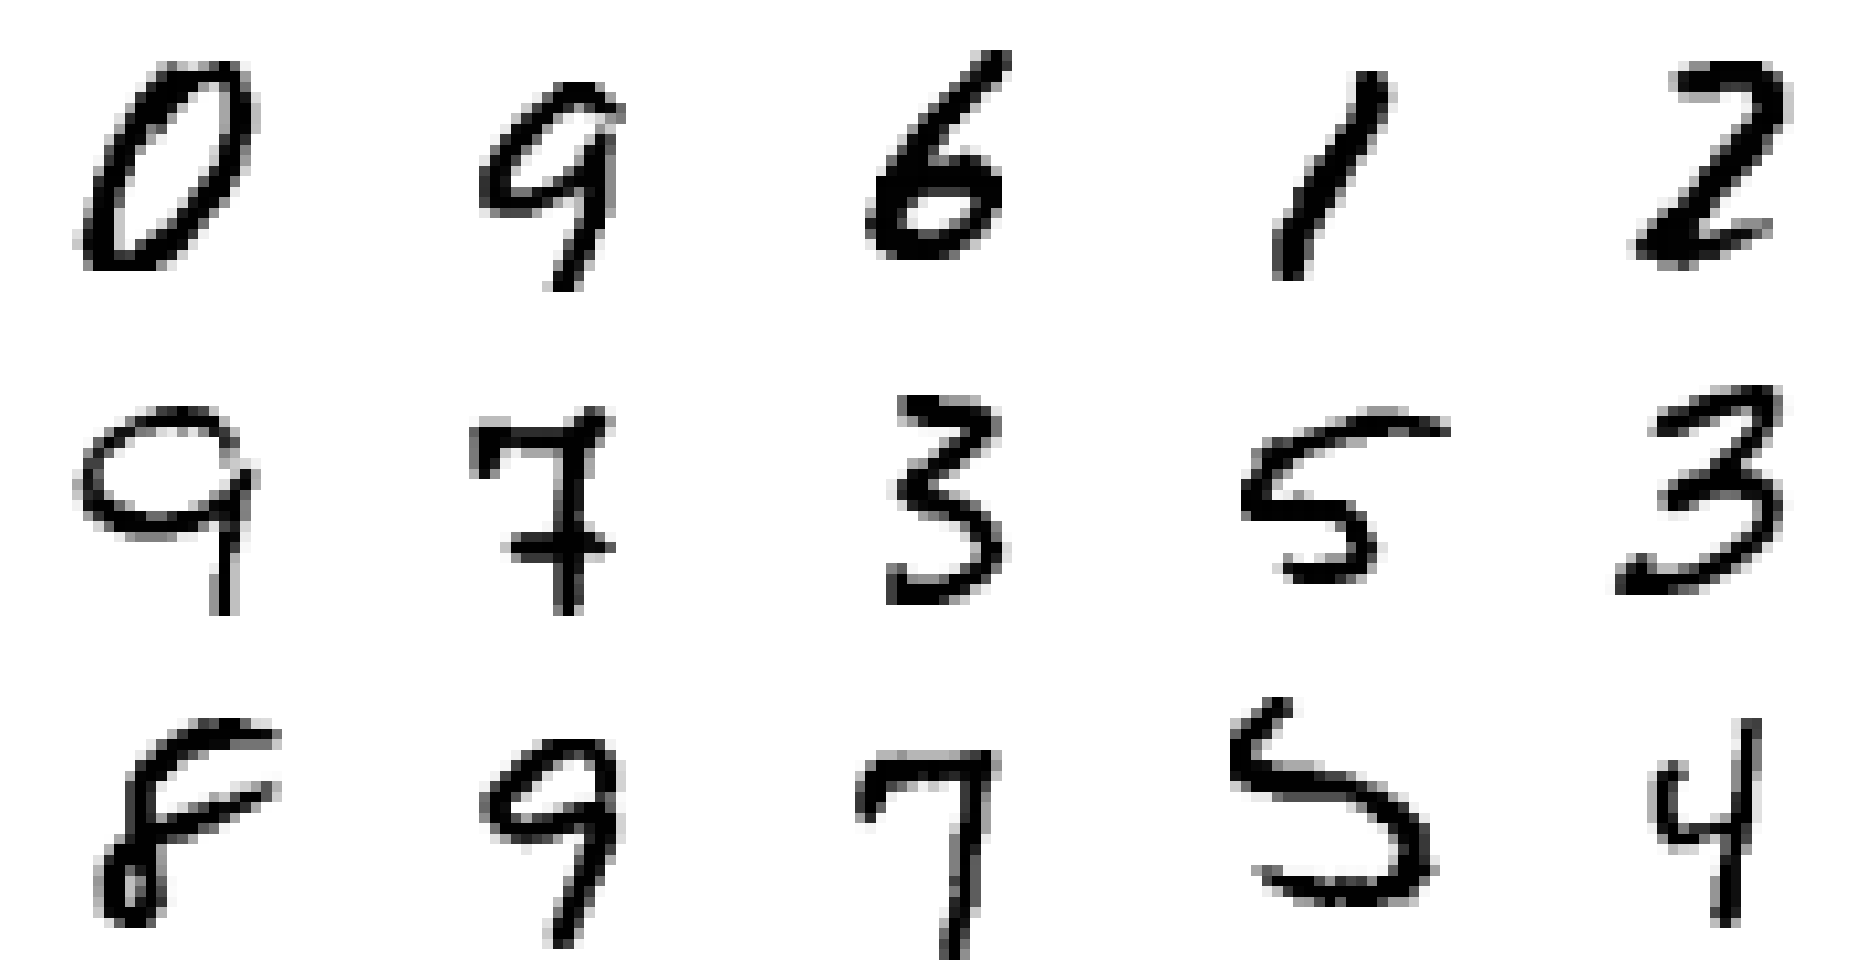

In [14]:
import matplotlib.pyplot as plt

# Assuming train_clean_X is a DataFrame with images in a flattened format

# Define the number of rows and columns for your grid
n_rows = 3
n_cols = 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5))

# Flatten the 2D grid of axes so you can iterate over it
axes = axes.ravel()

for i in range(n_rows * n_cols):
    image_pixels = train_clean_X.iloc[i].values.reshape(28, 28)
    axes[i].imshow(image_pixels, cmap='binary')
    axes[i].axis('off')  # to turn off axis numbers

plt.tight_layout()
plt.show()


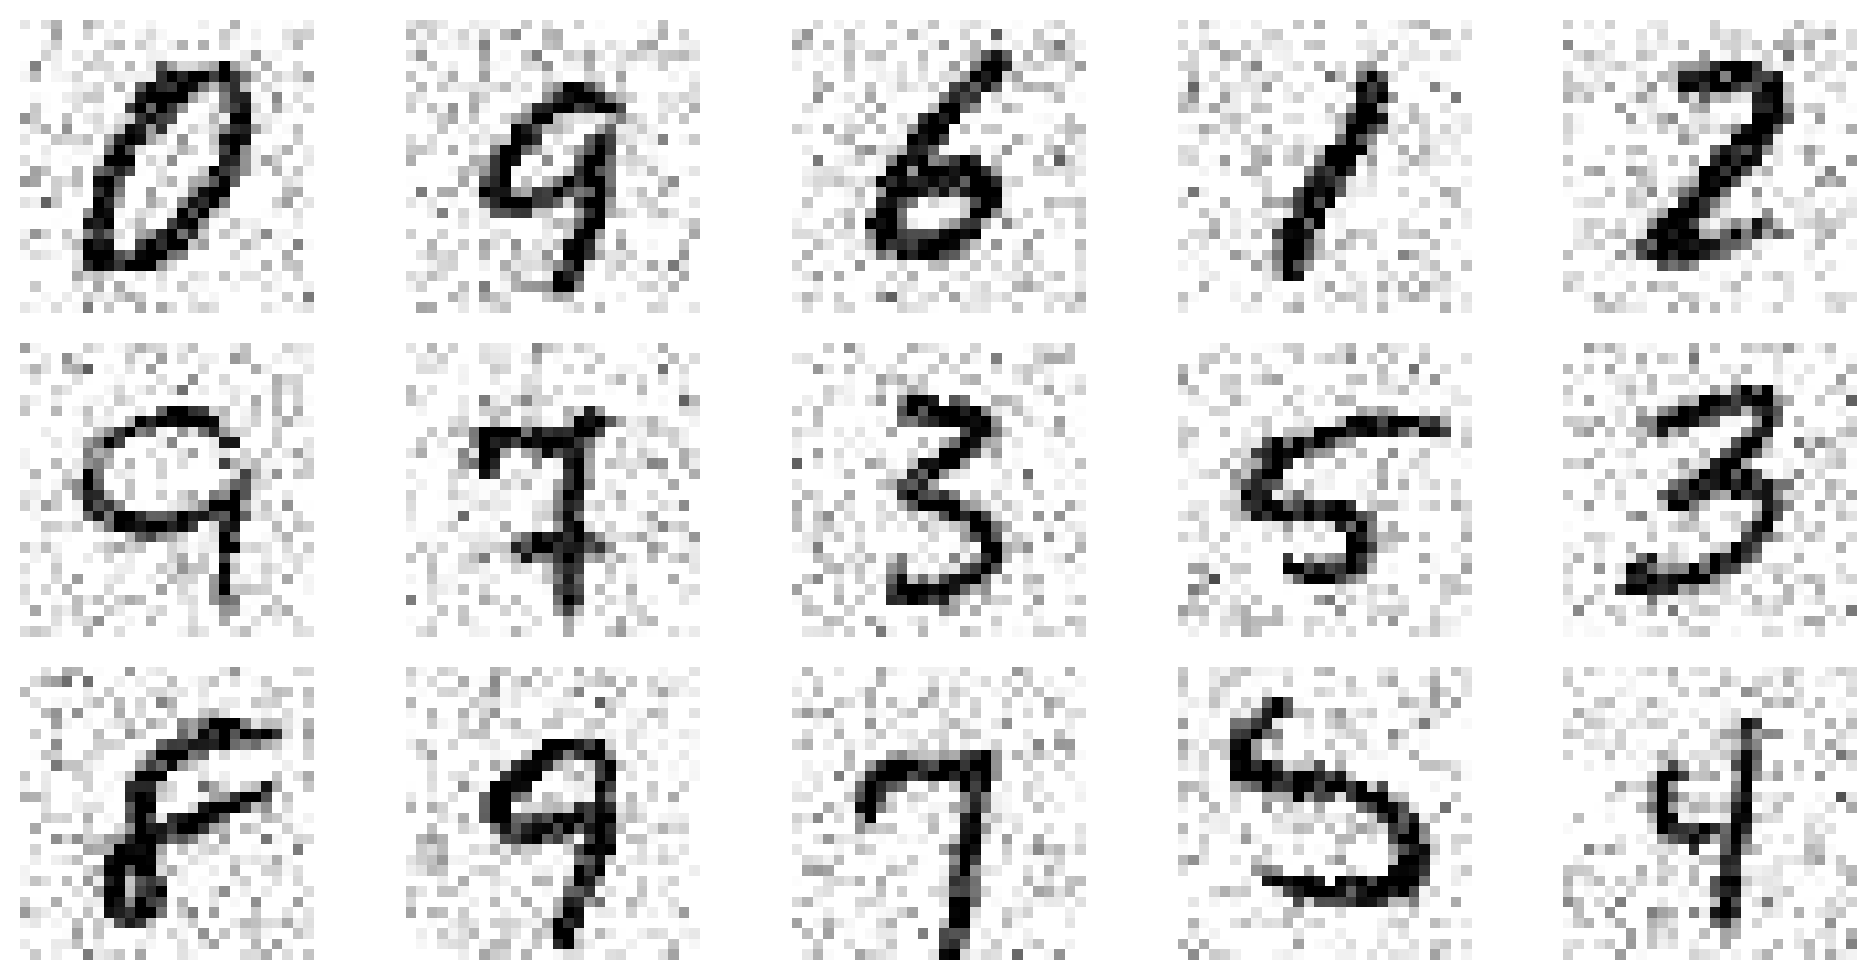

In [15]:
import matplotlib.pyplot as plt

# Define the number of rows and columns for your grid
n_rows = 3
n_cols = 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5))

# Flatten the 2D grid of axes so you can iterate over it
axes = axes.ravel()

for i in range(n_rows * n_cols):
    image_pixels = train_noisy_X.iloc[i].values.reshape(28, 28)
    axes[i].imshow(image_pixels, cmap='binary')
    axes[i].axis('off') 

plt.tight_layout()
plt.show()


In [18]:
# configure Tensorflow to use your GPU
import tensorflow as tf
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

In [19]:
import mlflow
mlflow.set_experiment('image_denoise')
mlflow.tensorflow.autolog(log_models=False, log_input_examples=False, log_model_signatures=False, silent=True)


mlflow.get_experiment_by_name('image_denoise')

2023/10/24 13:01:41 INFO mlflow.tracking.fluent: Experiment with name 'image_denoise' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///app/mlflow/851867379306582168', creation_time=1698177701498, experiment_id='851867379306582168', last_update_time=1698177701498, lifecycle_stage='active', name='image_denoise', tags={}>

In [ ]:
import random
import tqdm
import mlflow
from tensorflow.keras import initializers
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers 



runs = 5
learning_rate_logs = [random.uniform(-1.5, 0) for _ in range(runs)]
encoder_widths = [random.choice(range(45, 200, 5)) for _ in range(runs)]
initializers = [random.choice([initializers.GlorotUniform(), initializers.HeNormal()]) for _ in range(runs)]  # Using initializer instances
seeds = [random.randint(0, 1000000000) for _ in range(runs)]  # Using integer seeds for reproducibility
lr_decay_steps = [random.choice(range(5000, 20000, 1000)) for _ in range(runs)]  # Adjust ranges as per your task
lr_decay_rates = [random.uniform(0.8, 0.99) for _ in range(runs)]  # Adjust ranges as per your task

parameters = list(zip(learning_rate_logs, encoder_widths, initializers, seeds, lr_decay_steps, lr_decay_rates))

for (learning_rate_log, encoder_width, initializer, seed, decay_step, decay_rate) in tqdm.tqdm(parameters):
    with mlflow.start_run():
        autoencoder = build_model(encoder_width=encoder_width, 
                                  learning_rate_log=learning_rate_log,
                                  initializer=initializer, 
                                  seed=seed, 
                                  lr_decay_steps=decay_step, 
                                  lr_decay_rate=decay_rate)
        history = train_anomaly_model(autoencoder, epochs=50, verbose=0)


In [20]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import tensorflow as tf
import mlflow

def build_model(encoder_width: int, learning_rate_log: float, initializer: str, seed: int, lr_decay_steps: int, lr_decay_rate: float) -> tf.keras.Model:
    mlflow.log_param('encoder_width', encoder_width)
    mlflow.log_param('learning_rate_log', learning_rate_log)
    mlflow.log_param('initializer', initializer)
    mlflow.log_param('seed', seed)
    mlflow.log_param('lr_decay_steps', lr_decay_steps)
    mlflow.log_param('lr_decay_rate', lr_decay_rate)
    
    layers = [
        Dense(
            units=encoder_width, 
            activation='relu', 
            input_shape=(28 * 28,),
            kernel_initializer=initializer),
            BatchNormalization(),
                        

        Dense(units=28*28, activation='sigmoid')
        
    ]

    autoencoder = Sequential(layers)

    # Using MSE as the loss function, and Adam optimizer.
    autoencoder.compile(
        optimizer=optimizers.Adam(
            learning_rate=10 ** learning_rate_log
        ), 
        loss='mean_squared_error',
    )
    return autoencoder


import json
import uuid
import os

# This function will be used to save each trained model.
def save_model(model: tf.keras.Model, model_path: str):
    os.makedirs(model_path, exist_ok=True)
    tf.keras.models.save_model(model, f'{model_path}/model.keras')
    with open(f'{model_path}/architecture.json', 'w') as f:
        f.write(json.dumps(json.loads(model.to_json()), indent=True))


# This function can be used to load a previously trained model.
def load_model(model_path: str) -> tf.keras.Model:
    return tf.keras.models.load_model(f'{model_path}/model.keras')



from collegium.foundation.callbacks import MlflowCallback
import tempfile


def train_anomaly_model(model: tf.keras.Model, epochs: int, verbose: int = 10) -> tf.keras.callbacks.History:
    history = model.fit(
        x=train_noisy_X, 
        y=train_clean_X, 
        epochs=epochs,
        batch_size=128,
        shuffle=True,
        validation_data=(validate_noisy_X, validate_clean_X),
        callbacks=[MlflowCallback()],
        verbose=verbose
    )
    
    # Save model parameters to the file system and upload to MLFlow.
    with tempfile.TemporaryDirectory('wb') as d:
        model_path = f'{d}/model'
        save_model(model, model_path)
        mlflow.log_artifacts(d)
    
    return history

In [21]:
import random
import tqdm
import mlflow
from tensorflow.keras import initializers
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers 

runs = 5
learning_rate_logs = [random.uniform(-1.5, 0) for _ in range(runs)]
encoder_widths = [random.choice(range(45, 200, 5)) for _ in range(runs)]
initializers = [random.choice([initializers.GlorotUniform(), initializers.HeNormal()]) for _ in range(runs)]  # Using initializer instances
seeds = [random.randint(0, 1000000000) for _ in range(runs)]  # Using integer seeds for reproducibility
lr_decay_steps = [random.choice(range(5000, 20000, 1000)) for _ in range(runs)]  # Adjust ranges as per your task
lr_decay_rates = [random.uniform(0.8, 0.99) for _ in range(runs)]  # Adjust ranges as per your task

parameters = list(zip(learning_rate_logs, encoder_widths, initializers, seeds, lr_decay_steps, lr_decay_rates))

for (learning_rate_log, encoder_width, initializer, seed, decay_step, decay_rate) in tqdm.tqdm(parameters):
    with mlflow.start_run():
        autoencoder = build_model(encoder_width=encoder_width, 
                                  learning_rate_log=learning_rate_log,
                                  initializer=initializer, 
                                  seed=seed, 
                                  lr_decay_steps=decay_step, 
                                  lr_decay_rate=decay_rate)
        history = train_anomaly_model(autoencoder, epochs=50, verbose=0)


100%|██████████| 5/5 [10:14<00:00, 122.83s/it]


In [22]:
best_run = mlflow.get_run('6b4b1679f9df40ee9b9c07420f7f4dd2')
saved_model_path = mlflow.tracking.MlflowClient().download_artifacts(best_run.info.run_id, 'model')
autoencoder = load_model(saved_model_path)

In [24]:
# Now we can feed the noisy images into the autoencoder.
train_denoised_X = autoencoder.predict(test_noisy_X)

# Keras returns back a Numpy array, but we need Pandas dataframe,
# so let's quickly put the denoised images into a dataframe.
train_denoised_X = pd.DataFrame(train_denoised_X)

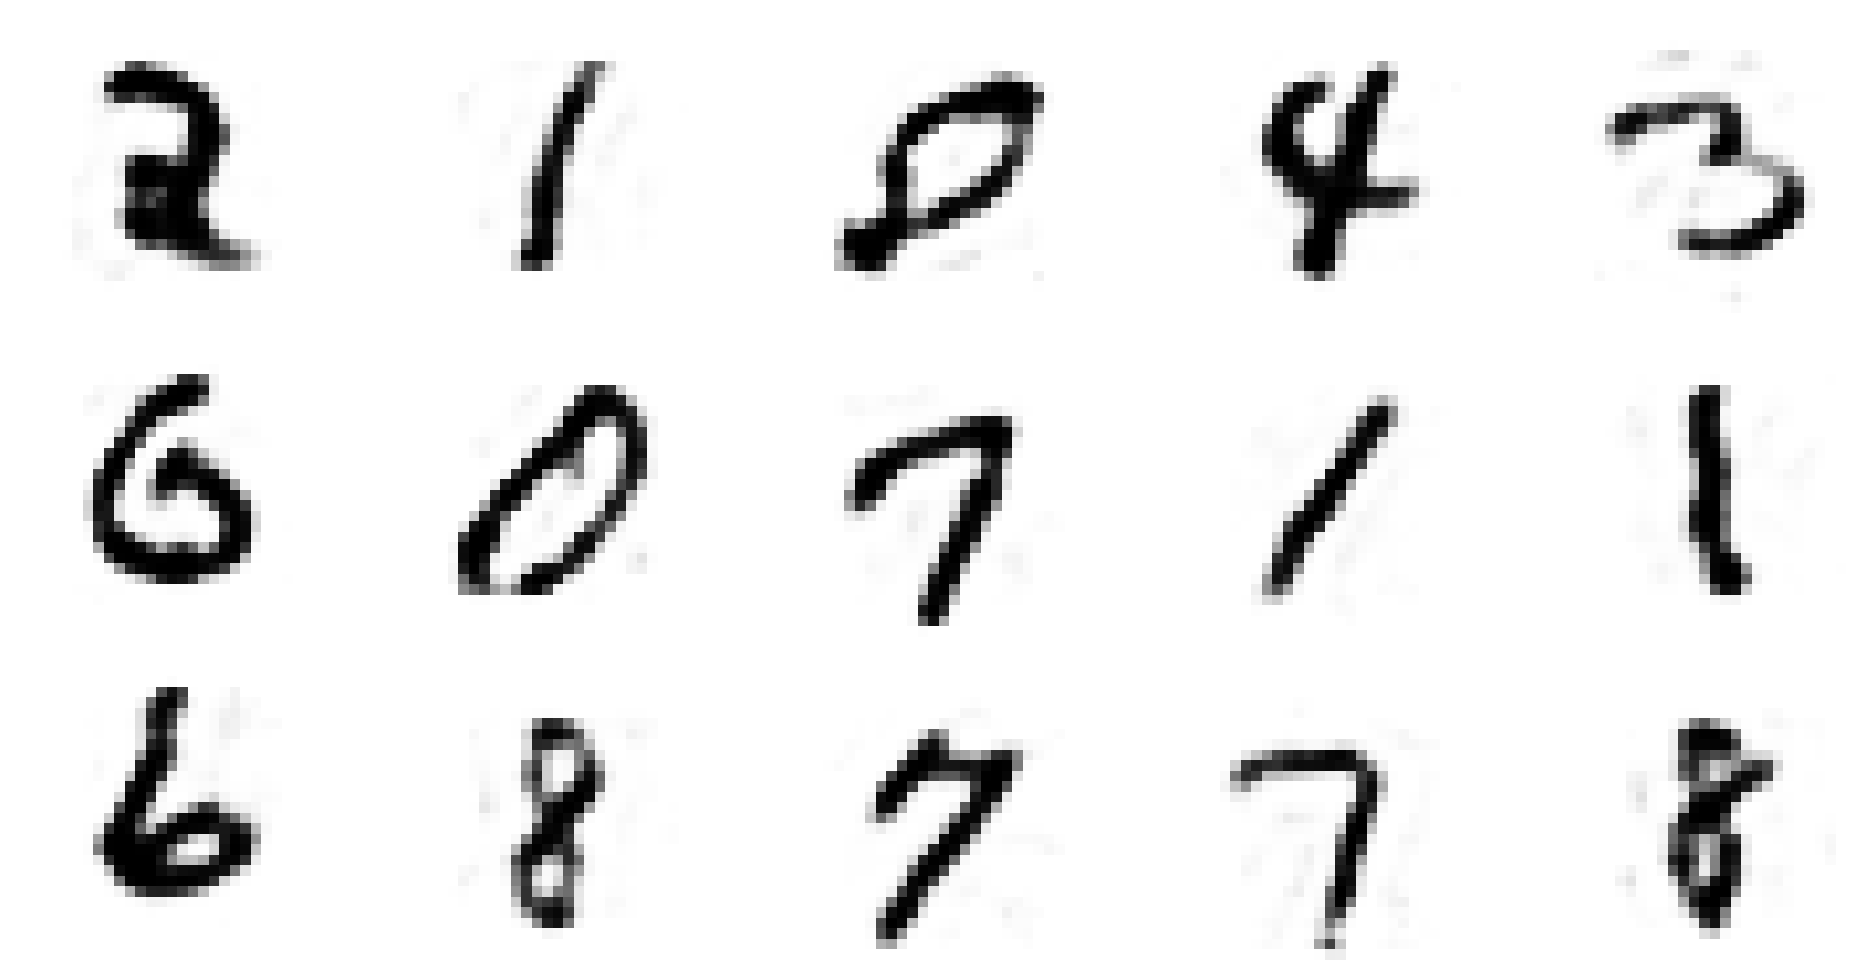

In [25]:
import matplotlib.pyplot as plt

# Assuming train_clean_X is a DataFrame with images in a flattened format

# Define the number of rows and columns for your grid
n_rows = 3
n_cols = 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5))

# Flatten the 2D grid of axes so you can iterate over it
axes = axes.ravel()

for i in range(n_rows * n_cols):
    image_pixels = train_denoised_X.iloc[i].values.reshape(28, 28)
    axes[i].imshow(image_pixels, cmap='binary')
    axes[i].axis('off')  # to turn off axis numbers

plt.tight_layout()
plt.show()


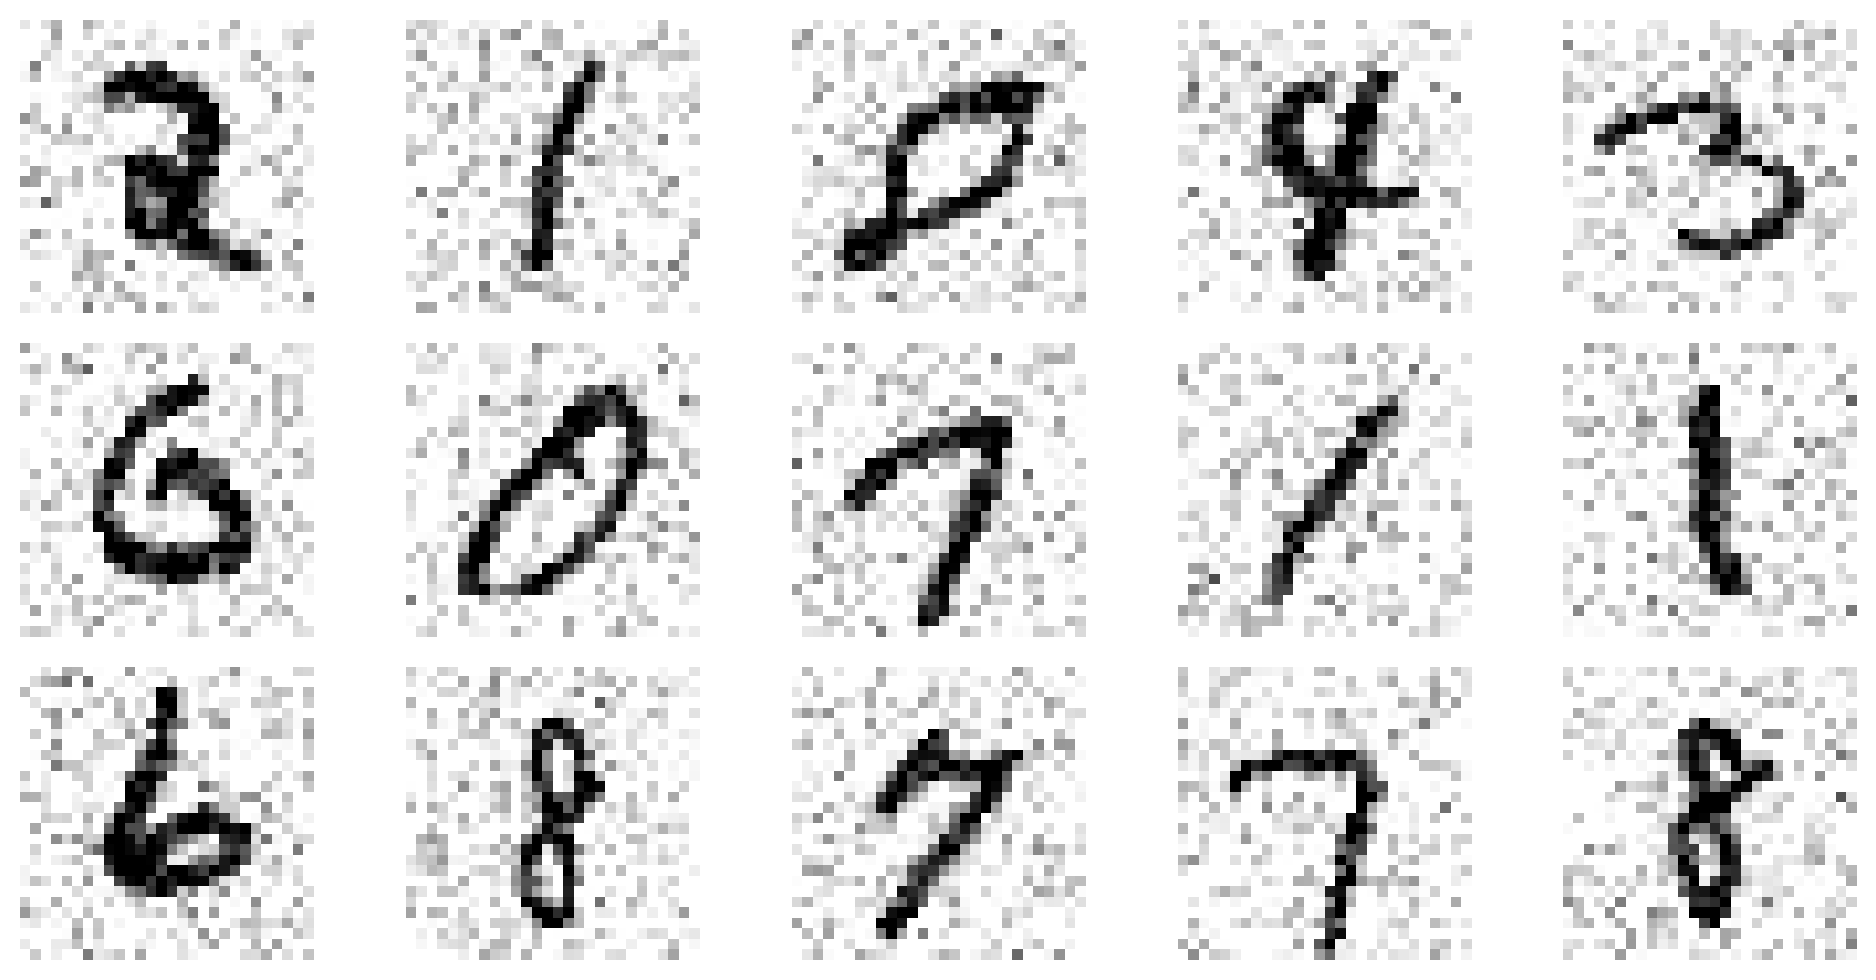

In [26]:
import matplotlib.pyplot as plt

# Assuming train_clean_X is a DataFrame with images in a flattened format

# Define the number of rows and columns for your grid
n_rows = 3
n_cols = 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5))

# Flatten the 2D grid of axes so you can iterate over it
axes = axes.ravel()

for i in range(n_rows * n_cols):
    image_pixels = test_noisy_X.iloc[i].values.reshape(28, 28)
    axes[i].imshow(image_pixels, cmap='binary')
    axes[i].axis('off')  # to turn off axis numbers

plt.tight_layout()
plt.show()


In [29]:
# To calculate MSE between two datasets with scikit-learn:

from sklearn.metrics import mean_squared_error

mean_squared_error(train_denoised_X, test_clean_X)

0.006570473